In [254]:
import numpy as np
import scipy as sp
from math import pi, sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

Essential Fourier functions for the boundaries

In [255]:
def y2(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

In [256]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))


sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])
s00=np.kron(sigma0,sigma0)
s30=np.kron(sigma3,sigma0)
s01=np.kron(sigma0,sigma1)
s02=np.kron(sigma0,sigma2)
s03=np.kron(sigma0,sigma3)


# def system_E_vs_k(m_sc,mu_sc,mu_n,ky_sw,Nx,Lx,Ls):
def system_E_vs_k(Nx,Lx,Ls,ky_sw,params):

    nu=params['nu']
    mu_n=nu*hwc 
    m_n=params['m_n']
    mu_sc=params['mu_sc']
    m_sc=params['m_sc']
    
    D1=params['D1']
    D2=params['D2']

    lRx= params['lRx']
    lRy= params['lRy']
    lso= params['lso']
    gs= params['gs']
    gn= params['gn']
    
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
    HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2,Lx,Ls)), sigma2)
    HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1,Lx,Ls)), sigma2)

    Hxm= np.kron( m_sc*y0s(k1-k2,Lx,Ls)+2*m_n*np.real(y0(k1-k2,Lx,Ls)) , sigma3)
    HxmT= np.kron( m_sc*y0s(k2-k1,Lx,Ls)+2*m_n*np.real(y0(k2-k1,Lx,Ls)) , sigma3)
    Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2,Lx,Ls) , lRx*sigma1)) #1
    HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1,Lx,Ls) , lRx*sigma1)) #1
    Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2,Lx,Ls) , lRy*sigma2)) #2
    HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1,Lx,Ls) , lRy*sigma2)) #2
    Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2,Lx,Ls) , lso*sigma3)) # 333
    HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1,Lx,Ls) , lso*sigma3))
    Hl=Hlx+Hly+Hlz
    HlT=HlxT+HlyT+HlzT
    # Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
    # HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2,Lx,Ls)) + mu_sc*y0s(k1-k2,Lx,Ls), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1,Lx,Ls)) + mu_sc*y0s(k2-k1,Lx,Ls), sigma0 )

    Hd= np.kron(y0s(k1-k2,Lx,Ls),sigma0)
    # basis ud,ud
    # dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
    # ddmat1=np.kron(dmat1,sigma2) 
    dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
    ddmat2=np.kron(dmat2,sigma2)
    Hd_mat=np.kron(ddmat2,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    s03=np.kron(sigma0,sigma3)
    Hz_up= -(gs*y0s(k1-k2,Lx,Ls)+2*gn*np.real(y0(k1-k2,Lx,Ls)))
    Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1,Lx,Ls)+2*gn*np.real(y0(k2-k1,Lx,Ls)))
    HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


    Vn=np.zeros((16*Nx,16*Nx,len(ky_sw)), dtype=np.complex64)
    En=np.zeros((16*Nx,len(ky_sw)))
    for i_y in range(len(ky_sw)):
        ky=ky_sw[i_y]
        Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

    #     Hly=hbar*lam*ky*np.kron(s01, np.kron(y0s(k1-k2),sigma0) )
    #     HlyT=-hbar*lam*ky*np.kron(s01, np.kron(y0s(k2-k1),sigma0) )

        H1 = Hx + np.kron(s00, Hy+ HeB + Hxm + Hef)+ Hz + Hl
        H1T = -Hx  + np.kron(s00,Hy+ (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

        H_t=block_diag(H1,-H1T)+Hd_mat
#         En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
        En[:,i_y] =np.linalg.eigvalsh(H_t)

    return En


# def sample_modes(m_sc,mu_sc,mu_n,Esw,Nx,Lx,Ls,lead_sample):
def sample_modes(Nx,Lx,Ls,lead_sample,E,params):

    nu=params['nu']
    mu_n=nu*hwc 
    m_n=params['m_n']
    mu_sc=params['mu_sc']
    m_sc=params['m_sc']
    
    D1=params['D1']
    D2=params['D2']

    lRx= params['lRx']
    lRy= params['lRy']
    lso= params['lso']
    gs= params['gs']
    gn= params['gn']

    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


    Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
    HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2,Lx,Ls)), sigma2)
    HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1,Lx,Ls)), sigma2)

    Hxm= np.kron( m_sc*y0s(k1-k2,Lx,Ls)+2*m_n*np.real(y0(k1-k2,Lx,Ls)) , sigma3)
    HxmT= np.kron( m_sc*y0s(k2-k1,Lx,Ls)+2*m_n*np.real(y0(k2-k1,Lx,Ls)) , sigma3)
    Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2,Lx,Ls) , lRx*sigma1)) #1
    HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1,Lx,Ls) , lRx*sigma1)) #1
    Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2,Lx,Ls) , lRy*sigma2)) #2
    HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1,Lx,Ls) , lRy*sigma2)) #2
    Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2,Lx,Ls) , lso*sigma3)) # 333
    HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1,Lx,Ls) , lso*sigma3))
    Hl=Hlx+Hly+Hlz
    HlT=HlxT+HlyT+HlzT
    # Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
    # HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2,Lx,Ls)) + mu_sc*y0s(k1-k2,Lx,Ls), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1,Lx,Ls)) + mu_sc*y0s(k2-k1,Lx,Ls), sigma0 )

    Hd= np.kron(y0s(k1-k2,Lx,Ls),sigma0)
    # basis ud,ud
    # dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
    # ddmat1=np.kron(dmat1,sigma2) 
    dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
    ddmat2=np.kron(dmat2,sigma2)
    Hd_mat=np.kron(ddmat2,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    s03=np.kron(sigma0,sigma3)
    Hz_up= -(gs*y0s(k1-k2,Lx,Ls)+2*gn*np.real(y0(k1-k2,Lx,Ls)))
    Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1,Lx,Ls)+2*gn*np.real(y0(k2-k1,Lx,Ls)))
    HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


#     Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)
    H1 = Hx + np.kron(s00, HeB + Hxm + Hef)+ Hz + Hl
    H1T = -Hx  + np.kron(s00, (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

    H_t=(block_diag(H1,-H1T)+Hd_mat)/(hbar*vF)*lB
  
    kmat=np.kron(sigma3, np.kron(np.eye(4*Nx),sigma2))

    ky_max = 4
    ky_min = 1e-5

    if lead_sample=='lead': 
#         En=(E+1e-3*hwc)/(hbar*vF)*lB
        En=E/(hbar*vF)*lB
        evs, evecs = np.linalg.eig( np.dot(kmat,En*np.eye(16*Nx)- H_t ) )
        i_evan= np.where( np.abs(np.imag(evs)) > ky_min )[0]
        ie_T= np.where( np.imag(evs[i_evan]) < 0)[0]
        i_e= i_evan[ie_T]

        i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
        i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
        i_prop3= np.where( np.abs(np.real(evs[i_prop1[i_prop2]])) < ky_max )[0]            
        Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])

        ip_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) > 0)[0]
        i_p= i_prop1[i_prop2[i_prop3[ip_T]]]
        ptcl= np.sum(np.abs(evecs[:8*Nx,i_p])**2,axis=0)
        hole= np.sum(np.abs(evecs[8*Nx:,i_p])**2,axis=0)
        hz= ptcl-hole
        i_ppt= np.where(ptcl-hole > 0)[0]
#             i_phl= np.where(ptcl-hole < 0)[0]
             
        in_T= np.where( np.real(Jmat[i_prop1[i_prop2]]) < 0)[0]
        i_n= i_prop1[i_prop2[in_T]]
        ptcl= np.sum(np.abs(evecs[:8*Nx,i_n])**2,axis=0)
        hole= np.sum(np.abs(evecs[8*Nx:,i_n])**2,axis=0)
        hz= ptcl-hole
        i_npt= np.where(ptcl-hole > 0)[0]
        i_nhl= np.where(ptcl-hole < 0)[0]
#             num_refl=len(i_n)/2
#             assert num_refl-int(num_refl)~=0, "Number of reflecting modes is %d" % (num_refl)
#             num_refl= int(num_refl)
        num_refl=[len(i_npt),len(i_n)]
        i_neg=np.concatenate((i_n[i_npt],i_n[i_nhl],i_e))

        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_p[i_ppt]]
        Revecs = evecs[:,i_neg]

        return num_refl,Revecs,Tevecs, evs[i_neg] #evs[i_p[i_ppt]]

    elif lead_sample=='sample':
        En=E/(hbar*vF)*lB
        evs, evecs = np.linalg.eig( np.dot(kmat,En*np.eye(16*Nx)- H_t ) )
        i_evan= np.where( np.abs(np.imag(evs)) > ky_min )[0]
        ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
        i_e= i_evan[ie_T]

        i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
        i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
        Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])
#         Jdot = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),evecs)),[16*Nx,])
#         Jdot = np.reshape(np.dot(np.transpose(evecs).conj(),evecs)[10,:],[16*Nx,])
        
#         plt.figure()
#         plt.plot(np.real(Jdot),'o')
#         plt.show()

        ip_T= np.where( np.real(Jmat[i_prop1[i_prop2]]) > 0)[0]
        i_p= i_prop1[i_prop2[ip_T]]
        i_pos=np.concatenate((i_p,i_e))
        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_pos]
        return Tevecs, evs
    else:
        En=E/(hbar*vF)*lB
        evs, evecs = np.linalg.eig( np.dot(kmat,En*np.eye(16*Nx)- H_t ) )
        Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])

#         i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
#         i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
#         i_prop3= np.where( np.abs(np.real(evs[i_prop1[i_prop2]])) < ky_max )[0]            
#         ip_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) > 0)[0]
#         i_p= i_prop1[i_prop2[i_prop3[ip_T]]]
#         in_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) < 0)[0]
#         i_n= i_prop1[i_prop2[i_prop3[in_T]]]
        i_prop2= np.where( np.real(evs) > ky_min )[0]
        i_prop3= np.where( np.real(evs[i_prop2]) < ky_max )[0]            
#         ip_T= np.where( np.real(Jmat[i_prop2[i_prop3]]) > 0)[0]
#         i_p= i_prop2[i_prop3[ip_T]]
#         in_T= np.where( np.real(Jmat[i_prop2[i_prop3]]) < 0)[0]
#         i_n= i_prop2[i_prop3[in_T]]
        i_tot= i_prop2[i_prop3]
        evs_p=evs[i_tot]
        i_s= np.argsort(np.abs(evs_p))
#         evs_p= evs_p[i_si[:6]]
#         print(evs_p.shape)
#         i_sr= np.argsort(np.real(evs_p))
        return evs_p[i_s[::2]] #, Jmat[i_tot]


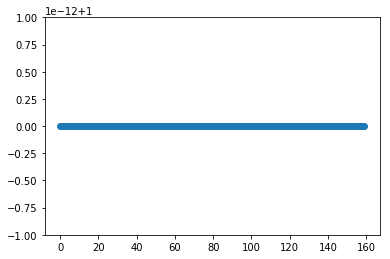

In [209]:
# check the orthonormality of sample modes
Ls=6*lB
Lx=8*lB
Nx=10

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc

nu=0.2
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

E=0.05*hwc
_ , _ = sample_modes(Nx,Lx,Ls,'sample',E,params)

In [262]:
Ls=6*lB
Lx=8*lB
Nx=100

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1.*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc

nu=1
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

m_sc_lead=4*hwc
mu_sc_lead=0*hwc
params_lead=dict(nu=nu, m_n=m_n, mu_sc=mu_sc_lead, m_sc=m_sc_lead, D1=0, D2=0,\
            lRx=lRx, lRy=lRy, lso=lso, gs=0, gn=gn)

# E_lead= 0.0*hwc
# kps_lead, kns_lead = sample_modes(Nx,Lx,Ls,'evals',E_lead,params_lead)
# print('Lead modes are prepared!')

E_sample= 0*hwc
# kps, kns = sample_modes(Nx,Lx,Ls,'evals',E_sample,params)
kps = sample_modes(Nx,Lx,Ls,'evals',E_sample,params)
print('Sample modes are prepared!')

ky_sw=np.linspace(0,1,100)*3/lB

Ek = system_E_vs_k(Nx,Lx,Ls,ky_sw,params)
print('Sample bands are done')
# # Ek0 = system_E_vs_k(Nx,Lx,Ls,ky_sw,params_lead)
# print('Lead bands are done')

Sample modes are prepared!
Sample bands are done


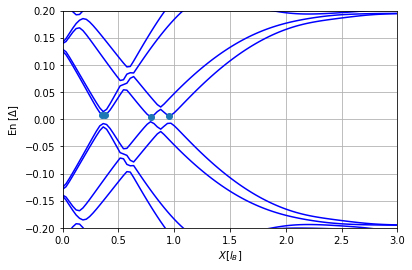

In [268]:
plt.figure()
# plt.plot(ky_sw*lB,Ek0.T/hwc,'g')
# Eps_lead=np.kron(np.ones(len(kps_lead)),E_lead)
# Ens_lead=np.kron(np.ones(len(kns_lead)),E_lead)
# # plt.plot(kps_lead,Eps_lead/hwc,'go')
# plt.plot(kns_lead,Ens_lead/hwc,'rv')

plt.plot(ky_sw*lB,Ek.T/hwc,'b')
# Eps=np.kron(np.ones(len(kps)),E_sample)
# Ens=np.kron(np.ones(len(kns)),E_sample)
# plt.plot(kps,Eps/hwc,'bo')
# plt.plot(kns,Ens/hwc,'bv')
# plt.plot(np.real(kps[0]),(np.imag(kps[0])),'bo')
plt.plot(kps,Egs/hwc,'o')
# plt.plot(np.imag(kps[:10]),'bo')
# plt.plot(np.real(kns),np.imag(kns)/4,'bv')

plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")
plt.ylim(-.2,.2)
plt.xlim(np.min(ky_sw)*lB,np.max(ky_sw)*lB)
plt.grid()
# print(kps)
# i1=np.where(np.abs(np.imag(kps))<0.2)[0]
# i2=np.where(np.real(kps[i1])>0.6)[0]
# i3=np.where(np.abs(np.real(kps[i1[i2]]))<0.8)[0]
# print(kps[i1[i2[i3]]],vps[i1[i2[i3]]])

In [277]:
# plot k points at minima vs nu

Ls=6*lB
Lx=8*lB
Nx=100

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1.*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.3*hwc

nu=0.4
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

E_sample= 0*hwc
nu_sw=np.linspace(0.21,1.6,200)
# nu_sw=np.array([1.0])
kps=np.zeros((4,len(nu_sw)))
Egs=np.zeros((4,len(nu_sw)))
for i_n in range(len(nu_sw)):
    print(i_n,end='\r')
    params['nu']=nu_sw[i_n]
    ks = sample_modes(Nx,Lx,Ls,'evals',E_sample,params)
    kps[:,i_n] = np.real(ks[0:4])
    Egs[:,i_n]= system_E_vs_k(Nx,Lx,Ls,kps[:,i_n]/lB,params)[8*Nx,:]

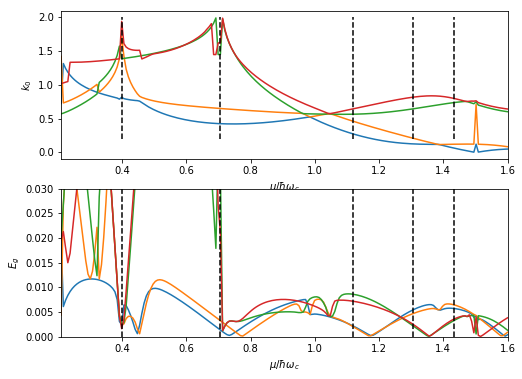

In [278]:
def plot_ll(Nll,ym):
    ill=np.arange(Nll)
    E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
    Eplot= np.concatenate((E1,E1),axis=0)
    yvals=np.reshape(ym,[2,1])
    plt.plot( Eplot-gn/hwc,yvals,'k--')
    plt.plot( Eplot+gn/hwc,yvals,'k--')
    plt.plot( -Eplot-gn/hwc,yvals,'k--')
    plt.plot( -Eplot+gn/hwc,yvals,'k--')


plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(nu_sw,kps.T)
y_nu=np.array([0.2,2])
plot_ll(4,y_nu)
plt.xlim(nu_sw.min(),nu_sw.max())
plt.xlabel(r'$\mu/\hbar\omega_c$')
plt.ylabel(r'$k_0$')
plt.subplot(2,1,2)
plt.plot(nu_sw,Egs.T/hwc)
y_E=np.array([0.,.1])
plot_ll(4,y_E)
plt.xlim(nu_sw.min(),nu_sw.max())
plt.ylim(0,0.03)
plt.xlabel(r'$\mu/\hbar\omega_c$')
plt.ylabel(r'$E_g$')
plt.show()

In [282]:
def wf_real_space(ev,k,x,Ls):
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:8*Nx,:]
    ev_p_K1 = ev_p[:4*Nx,:]
    ev_p_K2 = ev_p[4*Nx:,:]
    ev_h= ev[8*Nx:,:]
    ev_h_K1 = ev_h[:4*Nx,:]
    ev_h_K2 = ev_h[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K1[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h_K2[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

def plot_wf(iwf=0):

    x0=np.linspace(-1,1,500)*12*lB
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    wfpK1_uA,wfpK1_uB, wfpK1_dA,wfpK1_dB,\
    wfpK2_uA,wfpK2_uB, wfpK2_dA,wfpK2_dB,\
    wfhK1_uA,wfhK1_uB, wfhK1_dA,wfhK1_dB,\
    wfhK2_uA,wfhK2_uB, wfhK2_dA,wfhK2_dB =wf_real_space(Vn,kx,x0,Ls)
    
    plt.figure(figsize=(10,6))
    plt.subplot(2,2,1)
    plt.title('ky=%.2f+j%.2f' % (np.real(kvals[iwf]),np.imag(kvals[iwf])) )
#     plt.title('K1')
    plt.plot(x0/lB,np.abs(wfpK1_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK1_uB[:,iwf])**2,label=r'$eB\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK1_dA[:,iwf])**2,label=r'$eA\downarrow$')
    plt.plot(x0/lB,np.abs(wfpK1_dB[:,iwf])**2,label=r'$eB\downarrow$')

    plt.legend()
    plt.subplot(2,2,2)
    plt.title('K1')
    plt.plot(x0/lB,np.abs(wfhK1_uA[:,iwf])**2,label=r'$hA\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK1_uB[:,iwf])**2,label=r'$hB\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK1_dA[:,iwf])**2,label=r'$hA\downarrow$')
    plt.plot(x0/lB,np.abs(wfhK1_dB[:,iwf])**2,label=r'$hB\downarrow$')

    plt.legend()
    plt.subplot(2,2,3)
    plt.title('K2')
    plt.plot(x0/lB,np.abs(wfpK2_uA[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK2_uB[:,iwf])**2,label=r'$eB\uparrow$')
    plt.plot(x0/lB,np.abs(wfpK2_dA[:,iwf])**2,label=r'$eA\downarrow$')
    plt.plot(x0/lB,np.abs(wfpK2_dB[:,iwf])**2,label=r'$eB\downarrow$')

    plt.legend()
    plt.subplot(2,2,4)
    plt.title('K2')
    plt.plot(x0/lB,np.abs(wfhK2_uA[:,iwf])**2,label=r'$hA\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK2_uB[:,iwf])**2,label=r'$hB\uparrow$')
    plt.plot(x0/lB,np.abs(wfhK2_dA[:,iwf])**2,label=r'$hA\downarrow$')
    plt.plot(x0/lB,np.abs(wfhK2_dB[:,iwf])**2,label=r'$hB\downarrow$')

    plt.legend()

    plt.show()

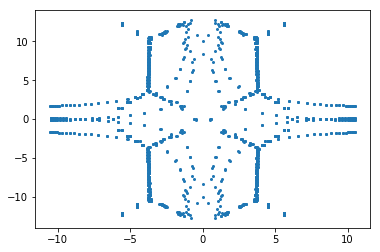

In [290]:
# m_sc_lead=10*hwc
# mu_sc_lead=0*hwc
# params_lead=dict(nu=0.11, m_n=0, mu_sc=mu_sc_lead, m_sc=m_sc_lead, D1=0, D2=0,\
#             lRx=lRx, lRy=lRy, lso=lso, gs=0, gn=gn)
# E_lead= 0.0*hwc
# num_refl , Vn , _ , kvals= sample_modes(Nx,Lx,Ls,'lead',E_lead,params_lead)
# print(num_refl)
# interact(plot_wf,iwf=(0,num_refl[1]-1,1));

E_sample=1e-3*hwc
Vn, kvals= sample_modes(Nx,Lx,Ls,'sample',E_sample,params)
# interact(plot_wf,iwf=(0,len(kvals)-1,1));
# #, continuous_update=False);

plt.figure()
plt.plot(np.real(kvals),np.imag(kvals),'o',markersize=2)
plt.show()

In [101]:
Ls=6*lB
Lx=10*lB
Nx=130

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.0*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc

nu=0.3
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

m_sc_lead=10*hwc
mu_sc_lead=.0*hwc
params_lead=dict(nu=nu, m_n=m_n, mu_sc=mu_sc_lead, m_sc=m_sc_lead, D1=0, D2=0,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

# Esw= np.array([0.05*hwc])
Esw=np.linspace(0.01,1,10)*0.03*hwc

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

E_lead= 0.0*hwc
num_refl,Revecs_l,Tevecs_l, _ = sample_modes(Nx,Lx,Ls,'lead',E_lead,params_lead)

for i_E in range(len(Esw)):
    print(i_E,end='\r')

#     num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,[Esw[i_E]],Nx,Lx,Ls,'lead')
    Tevecs, _ = sample_modes(Nx,Lx,Ls,'sample',Esw[i_E],params)

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
        
    if x.shape[1]>1:
        Ree[i_E]= np.real(np.trace(np.dot(np.matrix(x[:num_refl[0],:]).H,x[:num_refl[0],:])))
        Reh[i_E]= np.real(np.trace(np.dot(np.matrix(x[num_refl[0]:num_refl[1],:]).H,x[num_refl[0]:num_refl[1],:])))
#         Ree[i_E] = np.sum(np.sum(np.abs(x[:num_refl[0],:])**2,axis=0))
#         Reh[i_E] = np.sum(np.sum(np.abs(x[num_refl[0]:num_refl[1],:])**2,axis=0))
    else:
        Ree[i_E] = np.sum(np.abs(x[:num_refl[0]])**2,axis=0)
        Reh[i_E] = np.sum(np.abs(x[num_refl[0]:num_refl[1]])**2,axis=0)

    
print('Done!')

Done!


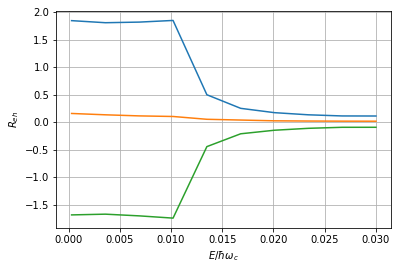

In [102]:
plt.figure()
plt.plot(Esw/hwc,Reh)
plt.plot(Esw/hwc,Ree)
plt.plot(Esw/hwc,Ree-Reh)
plt.grid()
# plt.ylim(0,1.1)
plt.ylabel(r'$R_{eh}$')
plt.xlabel(r'$E/\hbar\omega_c $')
plt.show()

In [366]:
# def plane_waves_T(Nx,Nd,Ld,Lx,Ls):
#     kx=np.reshape(2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls),[Nx,1])
#     evec=np.zeros((16*Nx,4*Nd), dtype=np.complex64)
#     v_p=np.kron(np.array([[1],[0]]),np.eye(4))
#     v_pos=np.array([[1],[1j]])/sqrt(2)
#     for n in range(1,Nd+1):
#         v1= np.exp(-1j*kx*(Ld+Ls/2))*(n*pi *(-np.exp(1j*kx*Ld)+np.cos(n*pi) )) \
#             *Ld/(kx**2 * Ld**2 - n**2 * pi**2)
#         v1= v1/np.linalg.norm(v1)
#         evec[:,4*(n-1):4*n]= np.kron(v_p,np.kron(v1,v_pos)) #/sqrt(Ld*(2*Lx+Ls))
#     return evec

# def plane_waves_R(Nx,Nd,L0,Ld,Lx,Ls,elec_hole):
#     kx=np.reshape(2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls),[Nx,1])
#     evec=np.zeros((16*Nx,4*Nd), dtype=np.complex64)
#     if elec_hole=='elec':
#         v_p=np.kron(np.array([[1],[0]]),np.eye(4))
#         v_neg=np.array([[1],[-1j]])/sqrt(2)
#     elif elec_hole=='hole':
#         v_p=np.kron(np.array([[0],[1]]),np.eye(4))
#         v_neg=np.array([[1],[1j]])/sqrt(2)
#     for n in range(1,Nd+1):
#         v1= np.exp(1j*kx*L0)*( n*pi - np.exp(1j*kx*Ld)*n*pi*np.cos(n*pi))\
#             *Ld/(kx**2 * Ld**2 - n**2 * pi**2)
#         v1= v1/np.linalg.norm(v1)
#         evec[:,4*(n-1):4*n]= np.kron(v_p,np.kron(v1,v_neg)) #/sqrt(Ld*(2*Lx+Ls))
#     return evec

def plane_waves(Nx,Lx,Ls,prop,elec_hole, top_bottom):
    kx=np.reshape(2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls),[Nx,1])
    kxp=np.reshape(4*pi*np.arange(Nx)/(2*Lx+Ls)-1*pi*Nx/(2*Lx+Ls),[Nx,1])
    evec=np.zeros((16*Nx,2*Nx), dtype=np.complex64)
    if elec_hole=='elec':
        v_p=np.kron(np.array([[1],[0]]),np.eye(4))
        v_pos=np.array([[1],[1j*prop]])/sqrt(2)
    elif elec_hole=='hole':
        v_p=np.kron(np.array([[0],[1]]),np.eye(4))
        v_pos=np.array([[1],[-1j*prop]])/sqrt(2)
    if top_bottom==  'top':   
        for n in range(0,int(Nx/2)):
            with np.errstate(divide='ignore', invalid='ignore'):
                c= (np.exp(-1j*(kxp[n]-kx)*(Lx+Ls/2))-1 )/(-1j*(kxp[n]-kx))/(2*Lx+Ls)
                c[ ~ np.isfinite( c )] = 1/2           
            evec[:,4*n:4*n+4]= np.kron(v_p,np.kron(c,v_pos))/np.linalg.norm(c)
    elif top_bottom==  'bottom':   
        for n in range(0,int(Nx/2)):
            with np.errstate(divide='ignore', invalid='ignore'):
                c= (np.exp(1j*(kxp[n]-kx)*(Lx+Ls/2))-1 )/(1j*(kxp[n]-kx))/(2*Lx+Ls)
                c[ ~ np.isfinite( c )] = 1/2           
            evec[:,4*n:4*n+4]= np.kron(v_p,np.kron(c,v_pos))/np.linalg.norm(c)
    return evec

def plane_waves_T(Nx,Nd,Ld,Lx,Ls):
    kx=np.reshape(2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls),[Nx,1])
    kxp=np.reshape(2*pi*np.arange(Nd)/Ld-pi*Nd/Ld,[Nd,1])
#     kxp=np.reshape(2*pi*np.arange(Nd)/Ld,[Nd,1])
    evec=np.zeros((16*Nx,4*Nd), dtype=np.complex64)
    v_p=np.kron(np.array([[1],[0]]),np.eye(4))
    v_pos=np.array([[1],[1j]])/sqrt(2)
    for n in range(0,Nd):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= (np.exp(1j*(kxp[n]-kx)*Ls/2)-np.exp(1j*(kxp[n]-kx)*(Ld+Ls/2)) )/(-1j*(kxp[n]-kx))
            c[ ~ np.isfinite( c )] = Ld          
        evec[:,4*n:4*n+4]= np.kron(v_p,np.kron(c.conj(),v_pos))/np.linalg.norm(c)
    return evec

Ls=6*lB
Lx=8*lB
Nx=100

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc

nu=0.2
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

m_sc_lead=10*hwc
mu_sc_lead=.0*hwc
params_lead=dict(nu=nu, m_n=m_n, mu_sc=mu_sc_lead, m_sc=m_sc_lead, D1=0, D2=0,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)

# Esw= np.array([0.05*hwc])
Esw=np.linspace(0.01,1,10)*0.02*hwc

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

# E_lead= 0.0*hwc
# num_refl,Revecs_l, _ , _ = sample_modes(Nx,Lx,Ls,'lead',E_lead,params_lead)

# NT_l=12 #int(Nx/4)
# LT_l=Lx/2
# Tevecs_l=plane_waves_T(Nx,NT_l,LT_l,Lx,Ls)
# NR_l=25
# Revecs_l1_p=plane_waves_R(Nx,NR_l,0,Lx/2,Lx,Ls,'elec')
# Revecs_l2_p=plane_waves_R(Nx,Nd,Lx/2,Lx,0,'elec')
# Revecs_l_h=plane_waves_R(Nx,Nd,Ld,Lx,Ls,'hole')
# Revecs_l= np.concatenate((Revecs_l_p,Revecs_l_h),axis=1)

v_p=np.array([[1],[0]])
v_h=np.array([[0],[1]])
v_pos=np.array([[1],[1j]])/sqrt(2)
v_neg=np.array([[1],[-1j]])/sqrt(2)
Revecs_l_p=np.kron(v_p,np.kron(np.eye(4*Nx),v_neg))
Revecs_l_h=np.kron(v_h,np.kron(np.eye(4*Nx),v_pos))
Revecs_l= np.concatenate((Revecs_l_p,Revecs_l_h),axis=1)
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
Xmat=np.kron(s00,y0(k2-k1,Lx,Ls))
Pin= np.kron(s00,np.reshape(y0(kx,Lx,Ls),[Nx,1]))
Pout= np.matrix(np.kron(s00,np.reshape(y0(-kx,Lx,Ls),[Nx,1]))).H

Tevecs_l=np.kron(v_p,np.kron(np.eye(4*Nx),v_pos))

# Nd=25
# Ld=Lx-lB
# Tevecs_l= plane_waves_T(Nx,Nd,Ld,Lx,Ls)
# Tevecs_l= np.kron(v_p,np.kron(np.eye(4),np.kron(np.reshape(y0(kx,Lx,Ls),[Nx,1]),v_pos)))

# Tevecs_l=plane_waves(Nx,Lx,Ls,+1,'elec', 'top')
# Revecs_l1_p=plane_waves(Nx,Lx,Ls,-1,'elec', 'bottom')
# Revecs_l2_p=plane_waves(Nx,Lx,Ls,-1,'elec', 'top')
# Revecs_l1_h=plane_waves(Nx,Lx,Ls,-1,'hole', 'bottom')
# Revecs_l2_h=plane_waves(Nx,Lx,Ls,-1,'hole', 'top')
# Revecs_l= np.concatenate((Revecs_l1_p,Revecs_l1_h,Revecs_l2_p,Revecs_l2_h),axis=1)
                    
for i_E in range(len(Esw)):
    print(i_E,end='\r')

    Tevecs, _ = sample_modes(Nx,Lx,Ls,'sample',Esw[i_E],params)

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
#     Ree[i_E]=np.real(np.trace(np.dot(np.matrix(x[:2*Nx,:]).H,x[:2*Nx,:])))
#     Reh[i_E]=np.real(np.trace(np.dot(np.matrix(x[2*Nx:4*Nx,:]).H,x[2*Nx:4*Nx,:])))

#     Ree[i_E]=np.real(np.trace(np.dot(np.matrix(x[:4*Nx,:]).H,x[:4*Nx,:])))
#     Reh[i_E]=np.real(np.trace(np.dot(np.matrix(x[4*Nx:8*Nx,:]).H,x[4*Nx:8*Nx,:])))

#     Ree[i_E]=np.real(np.trace(np.dot(np.matrix(x[:4*Nx,:]).H,np.dot(Xmat,x[:4*Nx,:]))) )
#     Reh[i_E]=np.real(np.trace(np.dot(np.matrix(x[4*Nx:8*Nx,:]).H,np.dot(Xmat,x[4*Nx:8*Nx,:]))) )
#     emat=np.dot(Pout,np.dot(x[:4*Nx,:],Pin))
#     hmat=np.dot(Pout,np.dot(x[4*Nx:8*Nx,:],Pin))
#     print(emat.shape)
#     Ree[i_E]= np.real(np.trace(np.dot(np.matrix(emat).H,emat)))
#     Reh[i_E]= np.real(np.trace(np.dot(np.matrix(hmat).H,hmat)))
#     emat=np.dot(np.dot(Xmat.conj(),np.matrix(x[:4*Nx,:]).H),np.dot(Xmat,x[:4*Nx,:]))
#     hmat=np.dot(np.dot(Xmat.conj(),np.matrix(x[4*Nx:8*Nx,:]).H),np.dot(Xmat,x[4*Nx:8*Nx,:]))
    Ree[i_E]=np.real( np.trace( np.dot( x[:4*Nx,:], np.dot(np.dot(Xmat.conj(),np.matrix(x[:4*Nx,:]).H ) , Xmat ) ) ))
    Reh[i_E]=np.real( np.trace( np.dot( x[4*Nx:8*Nx,:], np.dot(np.dot(Xmat.conj(),np.matrix(x[4*Nx:8*Nx,:]).H ) , Xmat ) ) ))


#     for i_1 in range(Nx):
#         inds= 4*i_1 + np.arange(4)
#         Ree[i_E] += np.real(np.sum(np.sum(emat[np.ix_(inds,inds)])))
#         Reh[i_E] += np.real(np.sum(np.sum(hmat[np.ix_(inds,inds)])))
    
#     Ree[i_E]=np.sum(np.sum(np.abs(x[:4*Nx,:])**2))
# #     Reh[i_E]=np.sum(np.sum(np.abs(x[4*Nx:,:])**2))

print('Done!')

Done!


In [259]:
Ls=6*lB
Lx=8*lB
Nx=100
# Nd=25
# Ld=Lx-lB
# Tevecs_l= plane_waves_T(Nx,Nd,Ld,Lx,Ls)
# # Revecs_l_p=plane_waves_R(Nx,Ld,Lx,Ls,'elec')
# # NR_l=25
# # Revecs_l1_p=plane_waves_R(Nx,NR_l,0,Lx/2,Lx,Ls,'elec')
# # Ld=Lx/212
# # Tevecs_l=plane_waves_T(Nx,Ld,Lx,Ls)
# vdot= np.dot(np.matrix(Tevecs_l).H,Tevecs_l)
# vdot_s=np.sort(np.abs(vdot[:,3]),axis=0)[::-1]
# print(vdot_s[:10])
# # vn=np.linalg.norm(Tevecs,axis=0)
# # print(vn[0])

Revecs_l1_p=plane_waves(Nx,Lx,Ls,-1,'elec', 'bottom')
Revecs_l2_p=plane_waves(Nx,Lx,Ls,-1,'elec', 'top')
vdot= np.dot(np.matrix(Revecs_l1_p).H,Revecs_l2_p)
vdot_s=np.sort(np.abs(vdot[:,0]),axis=0)[::-1]
print(vdot_s[:10])


[[0.33513692]
 [0.12122682]
 [0.08029103]
 [0.06159659]
 [0.05062813]
 [0.0433269 ]
 [0.03807836]
 [0.03410434]
 [0.0309803 ]
 [0.02845383]]


In [257]:
Ls=6*lB
Lx=8*lB
Nx=100
Nd=10
Ld=Lx

def plot_wf(n=0):
    kx=np.reshape(2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls),[Nx,1])
#     kxp=np.reshape(2*pi*np.arange(Nd)/Ld-pi*Nd/Ld,[Nd,1])
    kxp=np.reshape(4*pi*np.arange(Nx)/(2*Lx+Ls)-1*pi*Nx/(2*Lx+Ls),[Nx,1])
    kt=np.reshape(kx,[1,Nx])
    x0=np.linspace(-1,1,5000)*(Lx+Ls/2)
    xt=np.reshape(x0,[len(x0),1])
    
#     evec=np.zeros((Nx,1), dtype=np.complex64)
    with np.errstate(divide='ignore', invalid='ignore'):
#         c= (np.exp(1j*(kxp[n]-kx)*Ls/2)-np.exp(1j*(kxp[n]-kx)*(Ld+Ls/2)) )/(-1j*(kxp[n]-kx))
#         c[ ~ np.isfinite( c )] = Ld          
        c= (np.exp(-1j*(kxp[n]-kx)*(Lx+Ls/2))-1 )/(-1j*(kxp[n]-kx))/(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = 1/2           
    evec= c.conj()/np.linalg.norm(c)
    
    wf_1=np.dot(np.exp(1j*kt*xt),evec)/np.sqrt(2*Lx+Ls)*np.sqrt(x0[1]-x0[0])

    plt.figure()
    plt.plot(x0/lB,np.abs(wf_1)**2)

interact(plot_wf,n=(0,int(Nx/2)-1,1));

interactive(children=(IntSlider(value=0, description='n', max=49), Output()), _dom_classes=('widget-interact',…

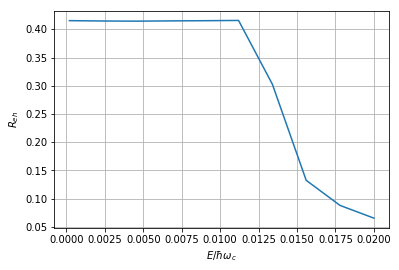

[0.41536774 0.41472446 0.41445998 0.41493546 0.41526926 0.41572617
 0.30272196 0.13258974 0.08817327 0.06566739]


In [370]:
plt.figure()
plt.plot(Esw/hwc,Reh)
# plt.plot(Esw/hwc,Ree)
# plt.plot(Esw/hwc,Ree-Reh)
plt.grid()
# plt.ylim(0,1.1)
plt.ylabel(r'$R_{eh}$')
plt.xlabel(r'$E/\hbar\omega_c $')
plt.show()
print(Reh)

In [ ]:
Ls=6*lB
Lx=8*lB
Nx=100

D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
gs=0.0*hwc
gn=0.2*hwc

nu=0.4
m_sc=3*hwc 
mu_sc=8*hwc
params=dict(nu=nu, m_n=m_n, mu_sc=mu_sc, m_sc=m_sc, D1=D1, D2=D2,\
            lRx=lRx, lRy=lRy, lso=lso, gs=gs, gn=gn)


# Esw= np.array([0.05*hwc])
Esw=np.linspace(0.01,1,10)*0.02*hwc

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

v_p=np.array([[1],[0]])
v_h=np.array([[0],[1]])

v_pos=np.array([[1],[1j]])/sqrt(2)
v_neg=np.array([[1],[-1j]])/sqrt(2)
Tevecs_l=np.kron(v_p,np.kron(np.eye(4*Nx),v_pos))
Revecs_l_p=np.kron(v_p,np.kron(np.eye(4*Nx),v_neg))
Revecs_l_h=np.kron(v_h,np.kron(np.eye(4*Nx),v_pos))
Revecs_l= np.concatenate((Revecs_l_p,Revecs_l_h),axis=1)

for i_E in range(len(Esw)):
    print(i_E,end='\r')

#     num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,[Esw[i_E]],Nx,Lx,Ls,'lead')
    Tevecs= sample_modes(Nx,Lx,Ls,'sample',Esw[i_E],params)

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
    Ree[i_E]=np.trace(np.dot(np.matrix(x[:4*Nx,:]).H,x[:4*Nx,:]))
    Reh[i_E]=np.trace(np.dot(np.matrix(x[4*Nx:,:]).H,x[4*Nx:,:]))
#     Ree[i_E]=np.sum(np.sum(np.abs(x[:4*Nx,:])**2))
#     Reh[i_E]=np.sum(np.sum(np.abs(x[4*Nx:,:])**2))



print('Done!')

In [ ]:
m_sc=3*hwc
mu_sc=8*hwc
m_sc_lead=1000*hwc
mu_sc_lead=0*hwc

Esw= np.array([0.002*hwc])
mu_n_sw=np.linspace(0.3,1.0,20)*hwc

Ree=np.zeros(len(mu_n_sw))
Reh=np.zeros(len(mu_n_sw))

for i_m in range(len(mu_n_sw)):
    print(i_m,end='\r')

    mu_n= mu_n_sw[i_m]
    num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,Esw,Nx,Lx,Ls,'lead')
    Tevecs= sample_modes(m_sc,mu_sc,mu_n,Esw,Nx,Lx,Ls,'sample')

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
    
    if x.shape[1]>1:
        Ree[i_m] = np.sum(np.sum(np.abs(x[:num_refl[0],:])**2,axis=0))
        Reh[i_m] = np.sum(np.sum(np.abs(x[num_refl[0]:num_refl[1],:])**2,axis=0))
    else:
        Ree[i_m] = np.sum(np.abs(x[:num_refl[0]])**2,axis=0)
        Reh[i_m] = np.sum(np.abs(x[num_refl[0]:num_refl[1]])**2,axis=0)


print('Done!')


In [ ]:
print(Revecs_l.shape)

In [ ]:
plt.figure()
plt.plot(mu_n_sw/hwc,Reh)
plt.plot(mu_n_sw/hwc,Ree)
plt.grid()
# plt.ylim(0,1.1)
plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$\mu_n/\hbar\omega_c $')
plt.show()

In [ ]:

plt.figure()
plt.plot(ky_sw*lB,Ek0.T/hwc,'g')
# Eps_lead=np.kron(np.ones(len(kps_lead)),Esw)
# Ens_lead=np.kron(np.ones(len(kns_lead)),Esw)
# plt.plot(kps_lead,Eps_lead/hwc,'go')
# plt.plot(kns_lead,Ens_lead/hwc,'gv')

plt.plot(ky_sw*lB,Ek.T/hwc,'b')
# Eps=np.kron(np.ones(len(kps)),Esw)
# Ens=np.kron(np.ones(len(kns)),Esw)
# plt.plot(kps,Eps/hwc,'bo')
# plt.plot(kns,Ens/hwc,'bv')

plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")
# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-0.1,0.1)
plt.grid()
# print(kps_lead)

Comparison with Andreev Edge state

In [ ]:
t_timer=time.time()

x0_kmin=1.8#-1.50

# Ls_sw=np.linspace(2,10,40)*lB
# Ls_sw=np.arange(2,11)*lB
Ls_sw=np.array([6])*lB
Nx2=200

# kmin=x0_kmin-0.2
# kmax=x0_kmin+0.2
# ky_sw=np.linspace(kmin,kmax,80)
ky_sw=np.linspace(0,3,40)#*2.0*np.sign(x0_kmin)
Ek2= np.zeros((len(ky_sw),len(Ls_sw)))
Eg_mat= np.zeros(len(Ls_sw))

Vp= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
Vh= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
kpt=np.zeros(len(Ls_sw))
for i_L in range(len(Ls_sw)):
    print(i_L, end='\r')
    Ls=Ls_sw[i_L]
    U2=0*hwc

#     f2=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx2,U2,Ls))
#     kx2,Em,Vm= system_builder(f2.x[0],Nx=Nx2,U0=U2,Ls=Ls)
#     kpt[i_L]=f2.x[0]
#     Eg_mat[i_L]=f2.fun
    Ek2[:,i_L]=system_E_vs_k(k0=ky_sw,Nx=Nx2,U0=0,Ls=Ls)

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
def plot_bands(i_L):
    pyplot.figure()
    pyplot.plot(ky_sw,Ek2[:,i_L],'b')
    pyplot.plot(kpt[i_L],Eg_mat[i_L],'ro')
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.show()

interact(plot_bands, i_L=(0,len(Ls_sw)-1,1));

In [ ]:
pyplot.figure()
pyplot.plot(Ls_sw/lB,Eg_mat)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$E_g$")
pyplot.show()

pyplot.figure()
pyplot.plot(Ls_sw/lB,kpt)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$k_0$")
pyplot.show()

# ratio=np.tan(abs(np.angle(Vp/Vh).T))**2
# pyplot.figure()
# # pyplot.plot(Ls_sw/lB,np.mod(np.angle(Vp/Vh).T/pi,1))
# pyplot.plot(Ls_sw/lB,np.abs(np.tan(theta)))
# # pyplot.plot(Ls_sw/lB,np.abs(Vp).T)
# # pyplot.plot(Ls_sw/lB,np.abs(Vh).T)
# # pyplot.plot(Ls_sw/lB,np.angle(Vp/Vh).T/pi)
# # pyplot.plot(Ls_sw/lB,ratio/(1+ratio))
# # pyplot.plot(Ls_sw/lB,Vh)
# pyplot.ylim([0.,0.1])
# pyplot.grid()
# pyplot.ylabel("p/h components")
# pyplot.xlabel(r"$k0*l_B$")
# pyplot.show()
# print(np.abs(theta/pi))

In [ ]:
# f1=minimize(system_E_vs_k,x0=0.8,args=(Nx1,U1,Ls1))
# kx1,Eb,Vb= system_builder(1.1*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
# wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)

def plot_wf(i_L):
    iwf=0
    pyplot.figure()
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h_arr[:,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_p_arr[:,iwf,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2/2)
#     pyplot.plot(x0/lB,np.real(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.real(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.01])
    pyplot.show()
    
interact(plot_wf, i_L=(0,len(Ls_sw)-1,1));

In [ ]:
Nx1=100
U1=100*hwc
Ls1=20*lB
# x0_kmin=[0.3,0.9,1.50,2.2]
x0=np.linspace(-1,1,1000)*20*lB


def plot_wf(i_L,x0_kmin):
    f1=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx1,U1,Ls1))
    print(f1.x[0])
    kx1,Eb,Vb= system_builder((1.+0.1*np.sign(f1.x[0]))*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
    wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)
    print(np.linalg.norm(wf1_p))
    
    iwf=0
    pyplot.figure()
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2/2)
    pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.imag(wf1_p))
# #     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.imag(wf2_p[:,iwf,i_L]))
#     pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.004])
    pyplot.show()
    
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.3,0.9,1.50,2.2]);
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.5,1.2]);

In [ ]:
plot_wf(i_L=0,x0_kmin=0.5)